<a href="https://colab.research.google.com/github/UlkuTuncerKucuktas/K9wJZlA0F9ANqa3T/blob/main/Task_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



1.   Data Preparation
2.   Forecast with VAR



**Data Preparation**

In [3]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [4]:
!unzip /content/drive/MyDrive/transactions.csv.zip

Archive:  /content/drive/MyDrive/transactions.csv.zip
  inflating: transactions.csv        
  inflating: __MACOSX/._transactions.csv  


In [5]:
import numpy as np
import pandas as pd

live_campain = pd.read_csv("/content/drive/MyDrive/live_digital_campaigns.csv")
economic_var =  pd.read_csv("/content/drive/MyDrive/economic_variables.csv")
economic_cal = pd.read_csv("/content/drive/MyDrive/economic_calendar.csv")
transactions = pd.read_csv("/content/transactions.csv")

In [25]:
live_campain['date'] = pd.to_datetime(live_campain['date'], format='%Y-%m-%d')
live_campain.head()

,date,live_campaign
0,2020-08-29,126
1,2020-08-30,121
2,2020-08-31,130
3,2020-09-01,134
4,2020-09-02,133


In [6]:
transactions.head()

,pk,ga_transactionid,ga_datehour,ga_products,ga_channels,ga_itemquantity
0,146288072,2_50414543,2020082900,Product D,Facebook,1
1,146288071,2_50414542,2020082900,Product D,Organic search,1
2,146287503,2_50413935,2020082900,Product D,Organic search,1
3,146287504,2_50413936,2020082900,Product D,Organic search,1
4,146296436,3_65496155,2020082900,Product E,Google Ads,1


In [7]:
transactions["ga_datehour"] = pd.to_datetime(transactions["ga_datehour"], format='%Y%m%d%H')
transactions = transactions.rename(columns={"ga_datehour":"date"})
transactions['date'] = transactions['date'].apply(lambda x: x.date())
transactions.head()

,pk,ga_transactionid,date,ga_products,ga_channels,ga_itemquantity
0,146288072,2_50414543,2020-08-29,Product D,Facebook,1
1,146288071,2_50414542,2020-08-29,Product D,Organic search,1
2,146287503,2_50413935,2020-08-29,Product D,Organic search,1
3,146287504,2_50413936,2020-08-29,Product D,Organic search,1
4,146296436,3_65496155,2020-08-29,Product E,Google Ads,1


In [19]:
channeldf = transactions.pivot_table('ga_itemquantity',['date'],'ga_channels',aggfunc=np.sum)
channeldf.reset_index(level=0, inplace=True)
channeldf['date'] = pd.to_datetime(channeldf['date'], format='%Y-%m-%d')
channeldf.head()

ga_channels,date,CRM,Direct,Facebook,Google Ads,Organic search,Referral
0,2020-08-29,2420,337,2123,21985,4938,389
1,2020-08-30,2611,376,2812,24524,5878,505
2,2020-08-31,3282,500,2921,33484,7915,580
3,2020-09-01,20859,501,2547,32932,7588,614
4,2020-09-02,11520,550,3065,30143,6998,616


In [ ]:
economic_var

,date,bist100,usdtry,eurtry,eurusd,faiz,xau,brent
0,2021-04-28,1388.59,8.2159,9.9379,1.2096,18.08,1773.86,67.33
1,2021-04-29,1398.85,8.1710,9.9166,1.2120,18.08,1780.19,67.54
2,2021-04-30,1401.52,8.2281,9.9741,1.2117,18.08,1769.11,68.08
3,2021-05-03,1421.15,8.2649,9.9694,1.2056,17.94,1793.31,67.45
4,2021-05-04,1421.15,8.2888,9.9721,1.2027,17.94,1785.86,67.43
...,...,...,...,...,...,...,...,...
619,2021-10-17,1409.56,9.2595,10.7585,1.1603,18.47,1767.62,84.86
620,2021-10-17,1409.56,9.2595,10.7585,1.1603,18.47,1767.62,84.86
621,2021-10-17,1409.56,9.2595,10.7585,1.1603,18.47,1767.62,84.86
622,2021-10-17,1409.56,9.2595,10.7585,1.1603,18.47,1767.62,84.86


In [ ]:
economic_var = economic_var[["date","bist100","usdtry","eurtry","eurusd",
                             "faiz","xau","brent"]]
economic_var['date'] = pd.to_datetime(economic_var['date'], format='%Y-%m-%d')
economic_var.head()

,date,bist100,usdtry,eurtry,eurusd,faiz,xau,brent
0,2021-04-28,1388.59,8.2159,9.9379,1.2096,18.08,1773.86,67.33
1,2021-04-29,1398.85,8.1710,9.9166,1.2120,18.08,1780.19,67.54
2,2021-04-30,1401.52,8.2281,9.9741,1.2117,18.08,1769.11,68.08
3,2021-05-03,1421.15,8.2649,9.9694,1.2056,17.94,1793.31,67.45
4,2021-05-04,1421.15,8.2888,9.9721,1.2027,17.94,1785.86,67.43


In [28]:
economic_var = economic_var.groupby("date",as_index=False).mean()
economic_var['date'] = pd.to_datetime(economic_var['date'], format='%Y-%m-%d')

economic_var = economic_var[["date","bist100","usdtry","eurtry","eurusd","faiz","xau","brent"]]
economic_var.head()

,date,bist100,usdtry,eurtry,eurusd,faiz,xau,brent
0,2021-04-28,1388.590000,8.2159,9.937900,1.2096,18.08,1773.860000,67.330000
1,2021-04-29,1398.850000,8.1710,9.916600,1.2120,18.08,1780.190000,67.540000
2,2021-04-30,1401.520000,8.2281,9.974100,1.2117,18.08,1769.110000,68.080000
3,2021-05-03,1421.150000,8.2649,9.969400,1.2056,17.94,1793.310000,67.450000
4,2021-05-04,1420.996667,8.3091,9.995333,1.2025,17.94,1787.523333,68.113333


In [29]:
economic_cal = economic_cal[["date","priority"]]
economic_cal['date'] = pd.to_datetime(economic_cal['date'], format='%Y-%m-%d')
economic_cal_sum = economic_cal.groupby("date",as_index=False).sum()
economic_cal_sum.head()

,date,priority
0,2021-04-26,258
1,2021-04-28,547
2,2021-04-29,559
3,2021-04-30,807
4,2021-05-03,313


In [31]:
mergedf = channeldf.merge(economic_var,on="date")
mergedf = mergedf.merge(economic_cal_sum,on="date")
mergedf = mergedf.merge(live_campain,on="date")
mergedf

,date,CRM,Direct,Facebook,Google Ads,Organic search,Referral,bist100,usdtry,eurtry,eurusd,faiz,xau,brent,priority,live_campaign
0,2021-04-28,11852,578,5356,24483,2313,211,1388.590000,8.215900,9.937900,1.209600,18.08,1773.860000,67.330000,547,112
1,2021-04-29,3271,433,4529,21608,1829,152,1398.850000,8.171000,9.916600,1.212000,18.08,1780.190000,67.540000,559,110
2,2021-04-30,2913,604,6764,25982,1896,199,1401.520000,8.228100,9.974100,1.211700,18.08,1769.110000,68.080000,807,109
3,2021-05-03,7218,819,9315,33252,2828,199,1421.150000,8.264900,9.969400,1.205600,17.94,1793.310000,67.450000,313,114
4,2021-05-04,15261,683,7947,31392,2602,197,1420.996667,8.309100,9.995333,1.202500,17.94,1787.523333,68.113333,416,114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,2021-10-13,6079,802,4576,33172,4341,96,1422.317500,9.049025,10.466625,1.156175,18.17,1774.517500,83.002500,353,131
149,2021-10-14,2848,747,4930,34627,4393,105,1415.100000,9.166200,10.648150,1.160150,18.32,1795.402500,84.040000,505,134
150,2021-10-15,3953,722,4327,32897,4175,66,1411.465000,9.208050,10.690100,1.160400,18.47,1783.125000,84.825000,677,135
151,2021-10-16,1318,493,4291,21555,2598,62,1409.560000,9.259500,10.758500,1.160300,18.47,1767.620000,84.860000,18,121


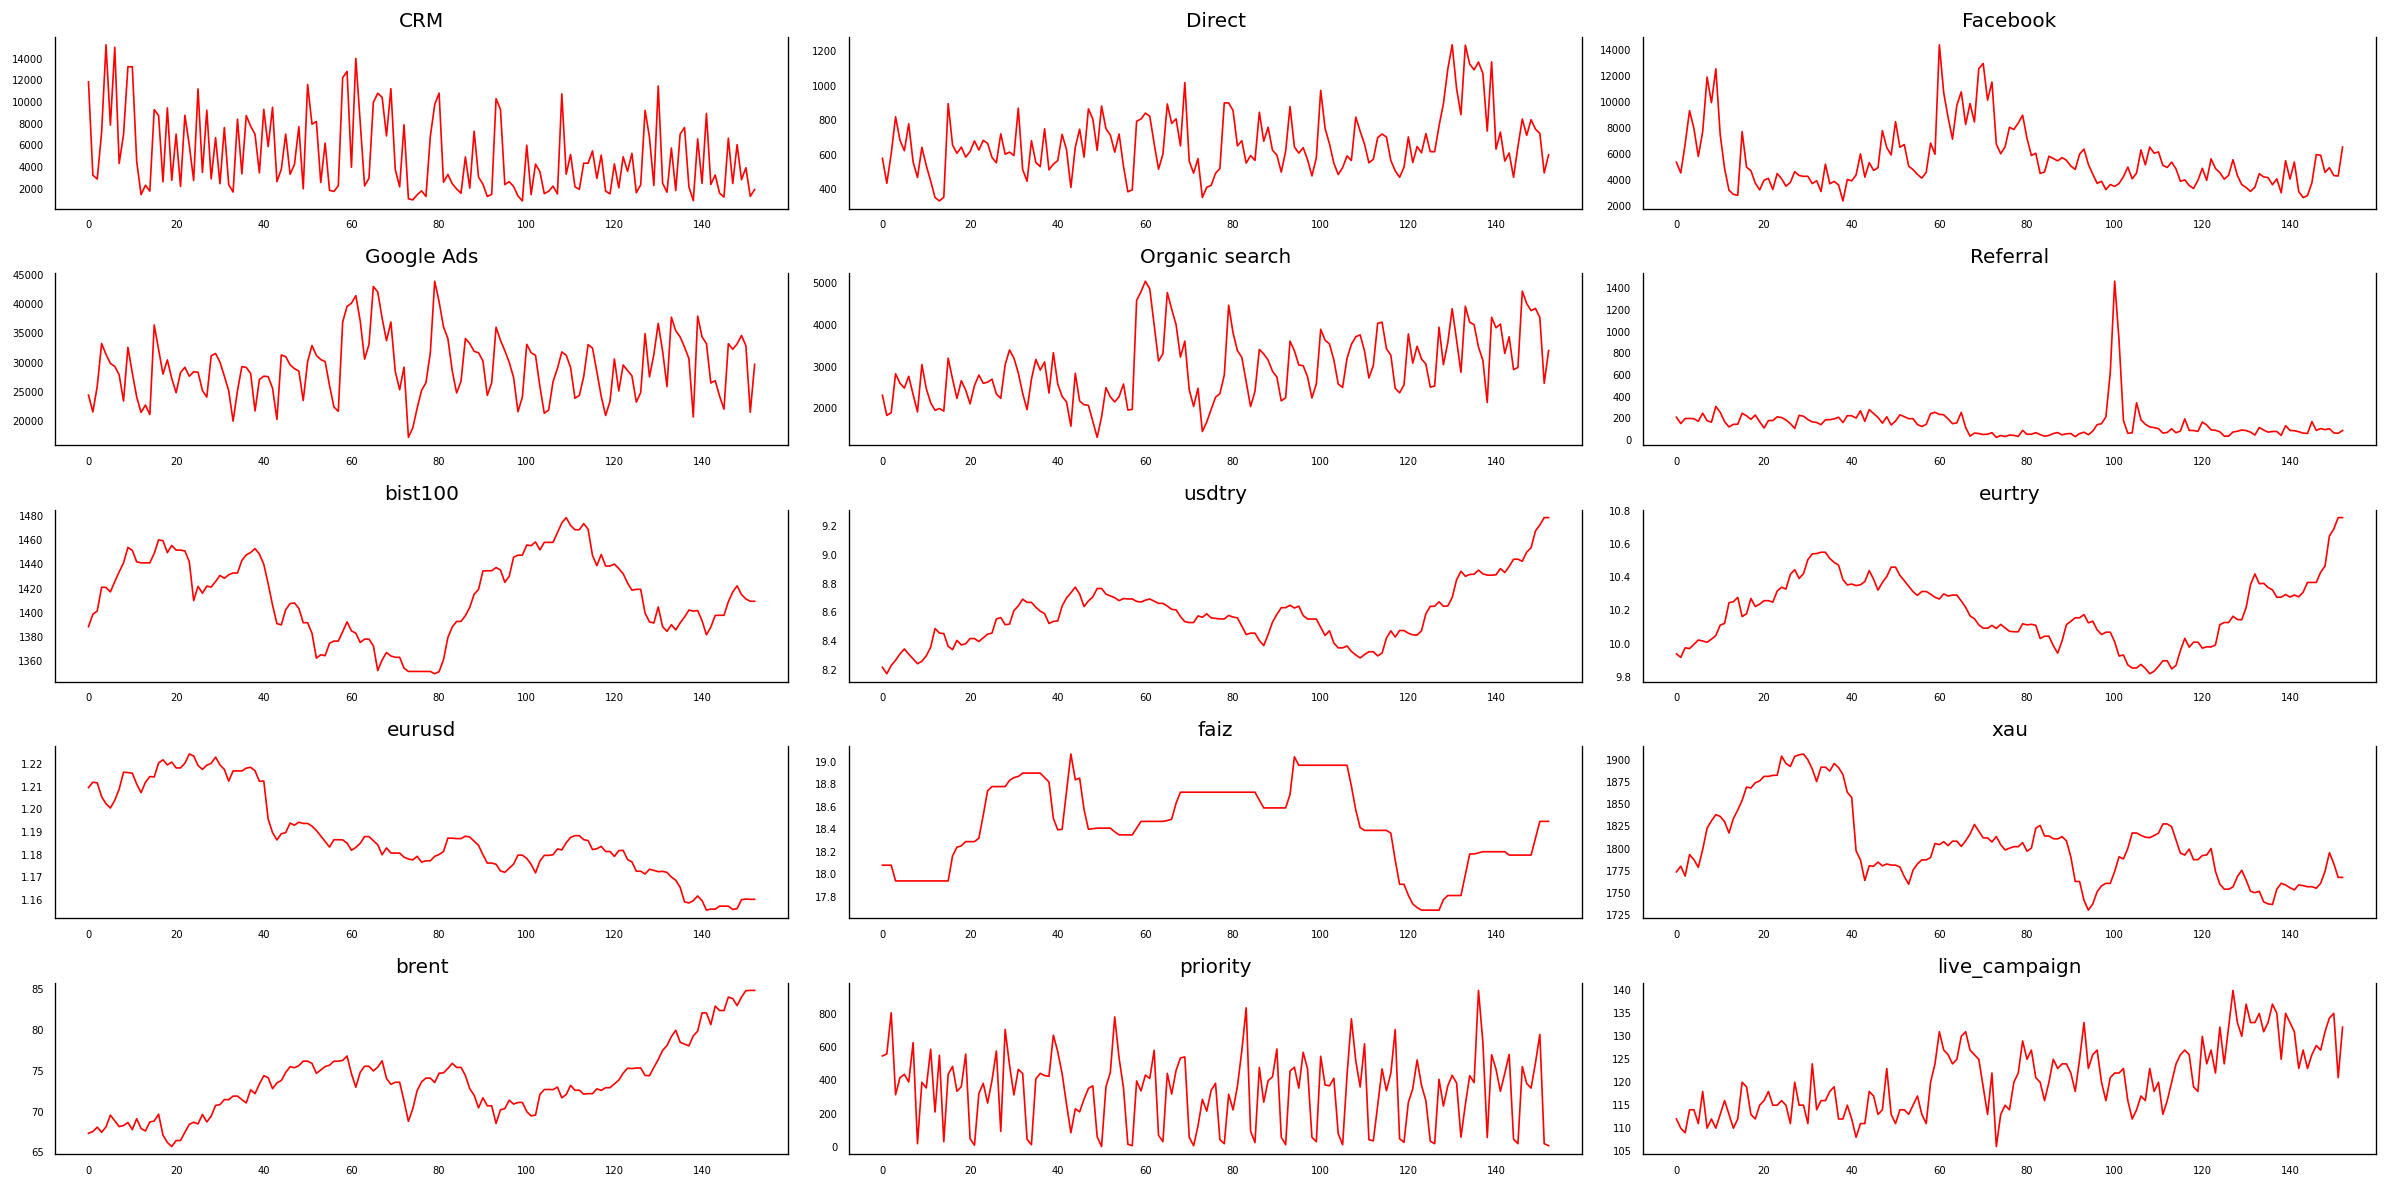

In [40]:
plotdf = mergedf[["CRM","Direct","Facebook","Google Ads","Organic search","Referral","bist100","usdtry","eurtry","eurusd","faiz","xau","brent","priority","live_campaign"]]
fig, axes = plt.subplots(nrows=5, ncols=3, dpi=120, figsize=(20,10))
for i, ax in enumerate(axes.flatten()):
    data = plotdf[plotdf.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(plotdf.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

**Forecast with var**

In [42]:
for i in ["faiz","bist100","usdtry","brent","priority","live_campaign"]:
  print('{} causes Google Ads or Facebook?\n'.format(i))
  print('------------------')
  granger_1 = grangercausalitytests(mergedf[[i, 'Google Ads']], 2)
  granger_2 = grangercausalitytests(mergedf[[i, 'Facebook']], 2)

faiz causes Google Ads or Facebook?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7005  , p=0.0182  , df_denom=149, df_num=1
ssr based chi2 test:   chi2=5.8153  , p=0.0159  , df=1
likelihood ratio test: chi2=5.7068  , p=0.0169  , df=1
parameter F test:         F=5.7005  , p=0.0182  , df_denom=149, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.5773  , p=0.0304  , df_denom=146, df_num=2
ssr based chi2 test:   chi2=7.3996  , p=0.0247  , df=2
likelihood ratio test: chi2=7.2240  , p=0.0270  , df=2
parameter F test:         F=3.5773  , p=0.0304  , df_denom=146, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9082  , p=0.3421  , df_denom=149, df_num=1
ssr based chi2 test:   chi2=0.9265  , p=0.3358  , df=1
likelihood ratio test: chi2=0.9237  , p=0.3365  , df=1
parameter F test:         F=0.9082  , p=0.3421  , df_denom=149, df_num=1

Granger Causality
number of lags (no 

In [124]:
CRMdf = mergedf[["CRM","Direct","Facebook","Google Ads","Organic search","Referral","bist100","usdtry",
                                "faiz","xau","brent","priority","live_campaign"]]
CRMdf.dropna(inplace=True)
CRMdf.head()

,CRM,Direct,Facebook,Google Ads,Organic search,Referral,bist100,usdtry,faiz,xau,brent,priority,live_campaign
0,11852,578,5356,24483,2313,211,1388.590000,8.2159,18.08,1773.860000,67.330000,547,112
1,3271,433,4529,21608,1829,152,1398.850000,8.1710,18.08,1780.190000,67.540000,559,110
2,2913,604,6764,25982,1896,199,1401.520000,8.2281,18.08,1769.110000,68.080000,807,109
3,7218,819,9315,33252,2828,199,1421.150000,8.2649,17.94,1793.310000,67.450000,313,114
4,15261,683,7947,31392,2602,197,1420.996667,8.3091,17.94,1787.523333,68.113333,416,114


In [125]:
train_df=CRMdf.copy()

In [126]:
train_df = train_df.astype(float)

In [127]:
train_df = train_df.loc[:, (train_df != train_df.iloc[0]).any()]

In [128]:
train_df

,CRM,Direct,Facebook,Google Ads,Organic search,Referral,bist100,usdtry,faiz,xau,brent,priority,live_campaign
0,11852.0,578.0,5356.0,24483.0,2313.0,211.0,1388.590000,8.215900,18.08,1773.860000,67.330000,547.0,112.0
1,3271.0,433.0,4529.0,21608.0,1829.0,152.0,1398.850000,8.171000,18.08,1780.190000,67.540000,559.0,110.0
2,2913.0,604.0,6764.0,25982.0,1896.0,199.0,1401.520000,8.228100,18.08,1769.110000,68.080000,807.0,109.0
3,7218.0,819.0,9315.0,33252.0,2828.0,199.0,1421.150000,8.264900,17.94,1793.310000,67.450000,313.0,114.0
4,15261.0,683.0,7947.0,31392.0,2602.0,197.0,1420.996667,8.309100,17.94,1787.523333,68.113333,416.0,114.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,6079.0,802.0,4576.0,33172.0,4341.0,96.0,1422.317500,9.049025,18.17,1774.517500,83.002500,353.0,131.0
149,2848.0,747.0,4930.0,34627.0,4393.0,105.0,1415.100000,9.166200,18.32,1795.402500,84.040000,505.0,134.0
150,3953.0,722.0,4327.0,32897.0,4175.0,66.0,1411.465000,9.208050,18.47,1783.125000,84.825000,677.0,135.0
151,1318.0,493.0,4291.0,21555.0,2598.0,62.0,1409.560000,9.259500,18.47,1767.620000,84.860000,18.0,121.0


In [129]:
model = VAR(train_df)

In [131]:
sorted_order=model.select_order(maxlags=5)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       102.3       102.6   2.773e+44       102.4
1      86.45*      90.14*  3.547e+37*      87.95*
2       86.74       93.85   4.943e+37       89.63
3       87.54       98.07   1.250e+38       91.82
4       87.99       101.9   2.508e+38       93.65
5       88.42       105.8   6.030e+38       95.48
-------------------------------------------------


In [133]:
var_model = VARMAX(train_df, order=(1,0),enforce_stationarity= True)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

                                                                                            Statespace Model Results                                                                                           
Dep. Variable:     ['CRM', 'Direct', 'Facebook', 'Google Ads', 'Organic search', 'Referral', 'bist100', 'usdtry', 'faiz', 'xau', 'brent', 'priority', 'live_campaign']   No. Observations:                  153
Model:                                                                                                                                                          VAR(1)   Log Likelihood               -9275.061
                                                                                                                                                           + intercept   AIC                          19096.123
Date:                                                                                                                                                 Mon, 08 Nov 2021  

In [134]:
n_forecast = 4
predict = fitted_model.get_prediction(start=len(train_df),end=len(train_df) + n_forecast-1)

In [136]:
predictions=predict.predicted_mean

predictions.columns=['CRM_predicted',"Direct_predicted","Facebook_predicted",
                     "Google Ads_predicted","Organic search_predicted","Referral_predicted",
                     'bist100_predicted','usdtry_predicted',
                     'faiz_predicted','xau_predicted','brent_predicted',
                     'priority_predicted','live_campaign_predicted']
predictions

,CRM_predicted,Direct_predicted,Facebook_predicted,Google Ads_predicted,Organic search_predicted,Referral_predicted,bist100_predicted,usdtry_predicted,faiz_predicted,xau_predicted,brent_predicted,priority_predicted,live_campaign_predicted
153,5438.601956,693.945901,6208.619381,31692.992070,3699.053815,152.957835,1402.515707,9.260824,18.511053,1763.829008,84.547189,121.456987,131.204528
154,5046.864069,700.202494,5861.038368,31941.459088,3757.758758,184.411099,1395.549885,9.264478,18.561565,1760.620182,84.478991,217.554425,129.922409
155,4885.022646,697.366368,5591.513000,31582.682146,3713.284367,194.629561,1389.947681,9.268327,18.608123,1758.472615,84.524148,239.433076,129.242507
156,4562.801610,696.032407,5461.680292,31298.093507,3674.167395,199.985539,1385.119666,9.270977,18.650384,1756.674982,84.621726,246.780247,128.815067
